In [1]:
%load_ext rpy2.ipython 

In [2]:
%%R 
w_max=m_max=40 

nt_init=matrix(0,nrow=w_max+1,ncol=m_max+1)
w_init=20
m_init=0
nt_init[w_init+1,m_init+1]=3.12e9
rownames(nt_init)=paste0('w',0:w_max)
colnames(nt_init)=paste0('m',0:m_max)

In [3]:
%%R
cell_division <- function(nt,k_lethal){
  nt_div=nt*0
  for(a in 0:(k_lethal-1)){ # wild-type 
    for(b in 0:(k_lethal-1-a)){ # mutant
      p_nt=dbinom(0:(a+b),a+b,0.5)*nt[a+1,b+1] 
      for(jpk in 0:(a+b)){ 
        j_all=max(0,jpk-b):min(a,jpk) 
        new_all=p_nt[jpk+1]*dhyper(j_all,a,b,jpk) 
        nt_div[(jpk-j_all)*(w_max+1)+j_all+1]=nt_div[(jpk-j_all)*(w_max+1)+j_all+1]+new_all 
        nt_div[(b-jpk+j_all)*(w_max+1)+a-j_all+1]=nt_div[(b-jpk+j_all)*(w_max+1)+a-j_all+1]+new_all 
      }
    }
  }
  return (nt_div)
}

plasmid_replication_mutation <- function(nt_div,u,r,R,k_lethal){
  nt_growth=nt_div*0
  for(a in 0:(k_lethal-1)){ # wild-type
    a_plus1=floor(a*r)
    new_wt=a_plus1-a
    w_to_m=0:new_wt
    a_plus2=a_plus1-w_to_m
    a_plus2=ifelse(a_plus2<=w_max,a_plus2,w_max) 
    
    p_w_to_m=dbinom(w_to_m,new_wt,u)
    
    for(b in 0:(k_lethal-1-a)){ # mutant
      b_plus1=floor(b*R)
      b_plus2=b_plus1+w_to_m
      new=nt_div[a+1,b+1]*p_w_to_m
      for (i in w_to_m[b_plus2<=m_max]+1){
          nt_growth[a_plus2[i]+1,b_plus2[i]+1]=nt_growth[a_plus2[i]+1,b_plus2[i]+1]+new[i]
      }
    }       
  }
  return (nt_growth)   
}

cell_g0_selection <-function(nt_growth, S, k_optimal, k_lethal){
  nt_selection=nt_growth*0
  
  for(a in 0:(k_lethal-1)){ # wild-type
    for(b in 0:(k_lethal-1-a)){ # mutant
      if ((a+b)==0){
        nt_selection[a+1,b+1]=0
      } else if ((a+b)<=k_optimal){
        nt_selection[a+1,b+1]=nt_growth[a+1,b+1]*(S+(1-S)*(a+b-1)/(k_optimal-1))
      } else {
        nt_selection[a+1,b+1]=nt_growth[a+1,b+1]*((k_lethal-a-b)/(k_lethal-k_optimal))
      }
    }
  }

  if (sum(nt_selection)<1){
    return (nt_selection*0)
  } else if (sum(nt_selection)>3.12e9){
    return (nt_selection*3.12e9/sum(nt_selection))
  }  else {
    return (nt_selection)
  }
}

cell_g1_selection<-function(nt_growth, k_lethal){
  rotate=function(mat){ t(mat[nrow(mat):1,,drop=FALSE]) }
  nt_selection=nt_growth*0
  nt_selection[seq_len(k_lethal),seq_len(k_lethal)][rotate(lower.tri(matrix(NA,nrow=k_lethal,ncol=k_lethal),diag=TRUE))]=
    nt_growth[seq_len(k_lethal),seq_len(k_lethal)][rotate(lower.tri(matrix(NA,nrow=k_lethal,ncol=k_lethal),diag=TRUE))]
  nt_selection[1,1]=0 # a+b=0
  
  if (sum(nt_selection)<1){
    return (nt_selection*0)
  } else if (sum(nt_selection)>3.12e9){
    return (nt_selection*3.12e9/sum(nt_selection))
  }  else {
    return (nt_selection)
  }
}

fcell_2_fplasmid <- function(nt_g0_selection,nt_g1_selection){
  nt_selection=nt_g0_selection+nt_g1_selection
  wt_plasmid=sum(nt_selection*(0:w_max))
  mutant_plasmid=sum(t(nt_selection)*(0:m_max))  
  return (mutant_plasmid/(wt_plasmid+mutant_plasmid))    
}

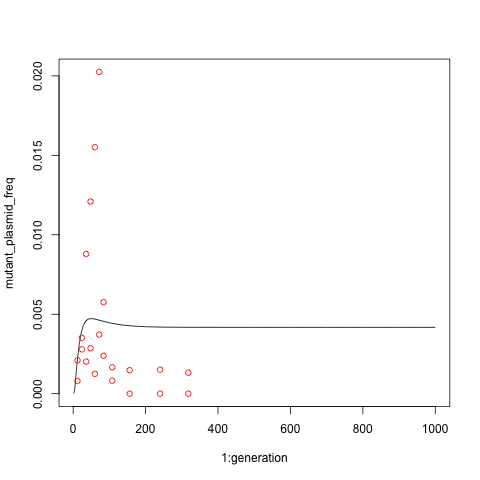

In [4]:
%%R
theta_optimized=c(0.001551366, 5.086873e-05, 1.53898, 3.41735, 0.7797591, 20.02272, 25.1642)
nt_g0_init=nt_init
nt_g1_init=nt_init*0

generation=1000
mutant_plasmid_freq=rep(-1,generation)
nt_g0=nt_g0_init
nt_g1=nt_g1_init

emperical_data=read.delim("F2_data.tab", header=TRUE)
emperical_generations=emperical_data$generations

trajectory = function (theta){
    gamma=theta[1]
    u=theta[2]
    r=theta[3]
    R=theta[4]
    S=theta[5]
    k_optimal=round(theta[6])
    k_lethal=round(theta[7])  
        
    for (i in 1:generation){
      nt_g0_div=cell_division(nt_g0,k_lethal)
      nt_g1_div=cell_division(nt_g1,k_lethal)
      
      nt_g1_div=nt_g1_div+nt_g0_div*gamma
      nt_g0_div=nt_g0_div-nt_g0_div*gamma
      
      nt_g0_growth=plasmid_replication_mutation(nt_g0_div,u,r,R,k_lethal)
      nt_g1_growth=plasmid_replication_mutation(nt_g1_div,u,r,R,k_lethal)
      
      nt_g0_selection=cell_g0_selection(nt_g0_growth, S, k_optimal, k_lethal)
      nt_g1_selection=cell_g1_selection(nt_g1_growth, k_lethal) 
      
      if (sum(nt_g0_selection)<1 | sum(nt_g1_selection)<1)
        return (+Inf)
      
      mutant_plasmid_freq[i]=fcell_2_fplasmid(nt_g0_selection,nt_g1_selection)
        
      nt_g0=nt_g0_selection
      nt_g1=nt_g1_selection
    }
    plot (1:generation,mutant_plasmid_freq,type='l',ylim=range(c(mutant_plasmid_freq,emperical_data$frequency)))
    points (emperical_generations,emperical_data$frequency,col='red')
    #return(list("nt_g0"=nt_g0,"nt_g1"=nt_g1))
    return(mutant_plasmid_freq)
}

mutant_plasmid_freq=trajectory(theta_optimized)
#nt_final=trajectory(theta_optimized)

#print("nt_final:")
#print(nt_final)

/Users/han/anaconda2/envs/ml/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/han/anaconda2/envs/ml/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  Ignoring unknown aesthetics: shape

  warnings.warn(x, RRuntimeWarning)


quartz_off_screen 
                2 


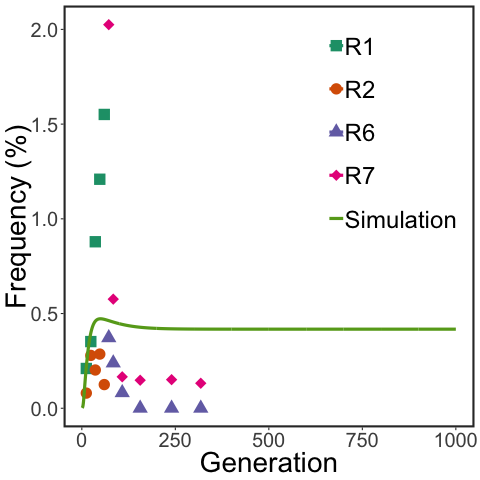

In [5]:
%%R
library(ggplot2)
data=data.frame(cbind(1:1000,mutant_plasmid_freq))
colnames(data)=c("generations","frequency")

lab=labs(x="Generation", y="Frequency (%)")

theme=theme(axis.title.x = element_text(size = 28),
            axis.title.y = element_text(size = 28),
            axis.text.x = element_text(size = 20), 
            axis.text.y = element_text(size = 20),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            panel.border = element_rect(size=2),
            legend.title = element_blank(), 
            legend.text = element_text(size = 24), 
            legend.position = c(0.8, 0.7), 
            legend.key.height=unit(3,"line")
)

cols<-c("R1" = '#1b9e77',
        "R2" = '#d95f02',
        "R6" = '#7570b3',
        "R7" = '#e7298a',
        "Simulation"= '#66a61e'
        )

shapes<-c("R1" = 15,
  "R2" = 16,
  "R6" = 17,
  "R7" = 18,
  "Simulation"= NA
  )

p = ggplot(emperical_data,aes(generations,frequency*100))+ geom_point(aes(col=replicate,shape=replicate),size=5) + 
    geom_line(aes(generations,frequency*100,col="Simulation",shape="Simulation"),data=data,size=1.5) +
    scale_colour_manual(values=cols) +
    scale_shape_manual(values=shapes) +
    lab + theme_bw() + 
    theme

print (p)
pdf("Figure_2.pdf",height=8.5, width=11)
print (p)
dev.off() 